# Class Workbook

## In class activity

In [2]:
import numpy as np
import pandas as pd
import math
#import statsmodels.api as sm
from plotnine import *
import statsmodels.formula.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                        summarize ,
                        poly)

### Ames House Data

In [3]:
ames_raw=pd.read_csv("ames_raw.csv")

In [10]:
ames_raw.head()

Order        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0      1  526301100           20        RL         141.0     31770   Pave   
1      2  526350040           20        RH          80.0     11622   Pave   
2      3  526351010           20        RL          81.0     14267   Pave   
3      4  526353030           20        RL          93.0     11160   Pave   
4      5  527105010           60        RL          74.0     13830   Pave   

  Alley Lot Shape Land Contour  ... Pool Area Pool QC  Fence Misc Feature  \
0   NaN       IR1          Lvl  ...         0     NaN    NaN          NaN   
1   NaN       Reg          Lvl  ...         0     NaN  MnPrv          NaN   
2   NaN       IR1          Lvl  ...         0     NaN    NaN         Gar2   
3   NaN       Reg          Lvl  ...         0     NaN    NaN          NaN   
4   NaN       IR1          Lvl  ...         0     NaN  MnPrv          NaN   

  Misc Val Mo Sold Yr Sold Sale Type  Sale Condition  SalePrice  
0        0       5    2010       WD           Normal     215000  
1        0       6    2010       WD           Normal     105000  
2    12500       6    2010       WD           Normal     172000  
3        0       4    2010       WD           Normal     244000  
4        0       3    2010       WD           Normal     189900  

[5 rows x 82 columns]

Let's revisit the AmesHousing data.  As we did in the previous class, I will split the data into before 2008 and after.  The data up to 2008 will be the training data and after 2008 will be the testing data.

In [4]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

* For the regression model fit, use bootstrap to compare the standard error estimates to the model based estimates.


Your code:

In [56]:
def prepare_and_fit_regression(data):
    # Defining the independent variables and dependent variable
    independent_vars = ['Overall Qual', 'Gr Liv Area', 'Bedroom AbvGr', 'Full Bath', 'Year Built']
    X = data[independent_vars]
    y = data['SalePrice']

    # Adding a constant for the intercept
    X = sm_api.add_constant(X)

    # Fitting the regression model
    model = sm_api.OLS(y, X).fit()
    return model

# Fit the regression model for both subsets
model_2009 = prepare_and_fit_regression(ames_raw_2009)
model_2008 = prepare_and_fit_regression(ames_raw_2008)

# Extract model-based standard errors for comparison later
model_se_2009 = model_2009.bse
model_se_2008 = model_2008.bse

model_se_2009



const            78411.243282
Overall Qual      1011.507593
Gr Liv Area          3.144742
Bedroom AbvGr     1432.334351
Full Bath         2450.318827
Year Built          41.184001
dtype: float64

In [50]:
model_se_2008

const            95761.521673
Overall Qual      1229.170130
Gr Liv Area          3.445835
Bedroom AbvGr     1662.944173
Full Bath         2870.854382
Year Built          50.328070
dtype: float64

In [62]:
from sklearn.utils import resample

independent_vars = ['Overall Qual', 'Gr Liv Area', 'Bedroom AbvGr', 'Full Bath', 'Year Built']
def bootstrap_coef(data, dependent_var, independent_vars, n_bootstrap=1000):
    coefs = np.zeros((n_bootstrap, len(independent_vars) + 1))  # +1 for the intercept
    for i in range(n_bootstrap):
        sample = resample(data)
        y_sample = sample[dependent_var]
        X_sample = sample[independent_vars]
        X_sample = sm_api.add_constant(X_sample)
        model = sm_api.OLS(y_sample, X_sample).fit()
        coefs[i, :] = model.params
    se_coefs = np.std(coefs, axis=0)
    return se_coefs

# Perform bootstrap analysis again with the reduced number of samples
bootstrap_se_2009_reduced = bootstrap_coef(ames_raw_2009, 'SalePrice', independent_vars, n_bootstrap=n_bootstrap_reduced)
bootstrap_se_2008_reduced = bootstrap_coef(ames_raw_2008, 'SalePrice', independent_vars, n_bootstrap=n_bootstrap_reduced)

bootstrap_se_2009_reduced, bootstrap_se_2008_reduced


(array([7.35409424e+04, 1.34713104e+03, 1.17549234e+01, 2.79606110e+03,
        4.58187621e+03, 3.89474979e+01]),
 array([8.91498720e+04, 1.67318175e+03, 1.11660457e+01, 3.12289148e+03,
        3.79638540e+03, 4.76421790e+01]))

Your answer:

~~~
Please write your answer in full sentences.


~~~


* Use cross validation  to decide which model has a good predictive accuracy.  Does the result hold true for the prediction of future data?

Your code:

In [64]:
#
#use cross-validation to decide which model has a good predictive accuracy
 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
 
# Define the independent variables and dependent variable
independent_vars = ['Overall Qual', 'Gr Liv Area', 'Bedroom AbvGr', 'Full Bath', 'Year Built']
X = ames_raw[independent_vars]
y = ames_raw['SalePrice']

# Create a linear regression model
model = LinearRegression()

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Calculate the average RMSE
cv_rmse = np.sqrt(-cv_results.mean())


# Perform 10-fold cross-validation for the 2009 subset
cv_results_2009 = cross_val_score(model, ames_raw_2009[independent_vars], ames_raw_2009['SalePrice'], cv=kf, scoring='neg_mean_squared_error')
cv_rmse_2009 = np.sqrt(-cv_results_2009.mean())

# Perform 10-fold cross-validation for the 2008 subset
cv_results_2008 = cross_val_score(model, ames_raw_2008[independent_vars], ames_raw_2008['SalePrice'], cv=kf, scoring='neg_mean_squared_error')
cv_rmse_2008 = np.sqrt(-cv_results_2008.mean())

cv_rmse_2009, cv_rmse_2008



(38334.772210730465, 40087.80272401873)

Your answer:

~~~
Please write your answer in full sentences.


~~~


* Using `knn.reg` fit KNN regression model.  Use cross validation to decide which K to use.

Your code:

In [65]:
#
#using knn.reg fit KNN regression model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


# Define the independent variables and dependent variable
independent_vars = ['Overall Qual', 'Gr Liv Area', 'Bedroom AbvGr', 'Full Bath', 'Year Built']
X = ames_raw[independent_vars]
y = ames_raw['SalePrice']

# Create a KNN regression model
model = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=10))

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=1)
cv_results = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Calculate the average RMSE
cv_rmse = np.sqrt(-cv_results.mean())

# Perform 10-fold cross-validation for the 2009 subset

cv_results_2009 = cross_val_score(model, ames_raw_2009[independent_vars], ames_raw_2009['SalePrice'], cv=kf, scoring='neg_mean_squared_error')
cv_rmse_2009 = np.sqrt(-cv_results_2009.mean())

# Perform 10-fold cross-validation for the 2008 subset
cv_results_2008 = cross_val_score(model, ames_raw_2008[independent_vars], ames_raw_2008['SalePrice'], cv=kf, scoring='neg_mean_squared_error')
cv_rmse_2008 = np.sqrt(-cv_results_2008.mean())

cv_rmse_2009, cv_rmse_2008



(33186.23372420419, 36739.05561113011)

Your answer:

~~~
Please write your answer in full sentences.


~~~


* Which model performs better on your training data?  Which model performs better in your future prediction?

Your code:

In [7]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

## Problem Set

### Bootstrap

We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We first create an array store with values that will subsequently
be overwritten using the function np.empty(). We then repeatedly create bootstrap samples, and each time we record whether or not the fifth observation is contained in the bootstrap
sample.

We will investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time
we record whether or not the fourth observation is contained in the bootstrap sample.

Here is the code to get you going

In [11]:
rng = np.random.default_rng (10)
store = np.empty (10000)
for i in range (10000):
    store[i] = np.sum(rng.choice(100, 100, replace=True) == 4) > 0


np.mean(store)

0.6362

Comment on the results obtained.


Your code:

In [9]:
# 
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

### CV

We will now perform cross-validation on a simulated data set.
(a) Generate a simulated data set as follows:

In [12]:
rng = np.random.default_rng(1)
x = rng.normal(size=100)
y = x - 2 * x**2 + rng.normal(size=100)


In this data set, what is n and what is p? Write out the model
used to generate the data in equation form.


Your code:

Your answer:

~~~
n = 100， p = 2
y = x - 2 * x^2 + e    
~~~


(b) Create a scatterplot of X against Y . Comment on what you find.


Your code:

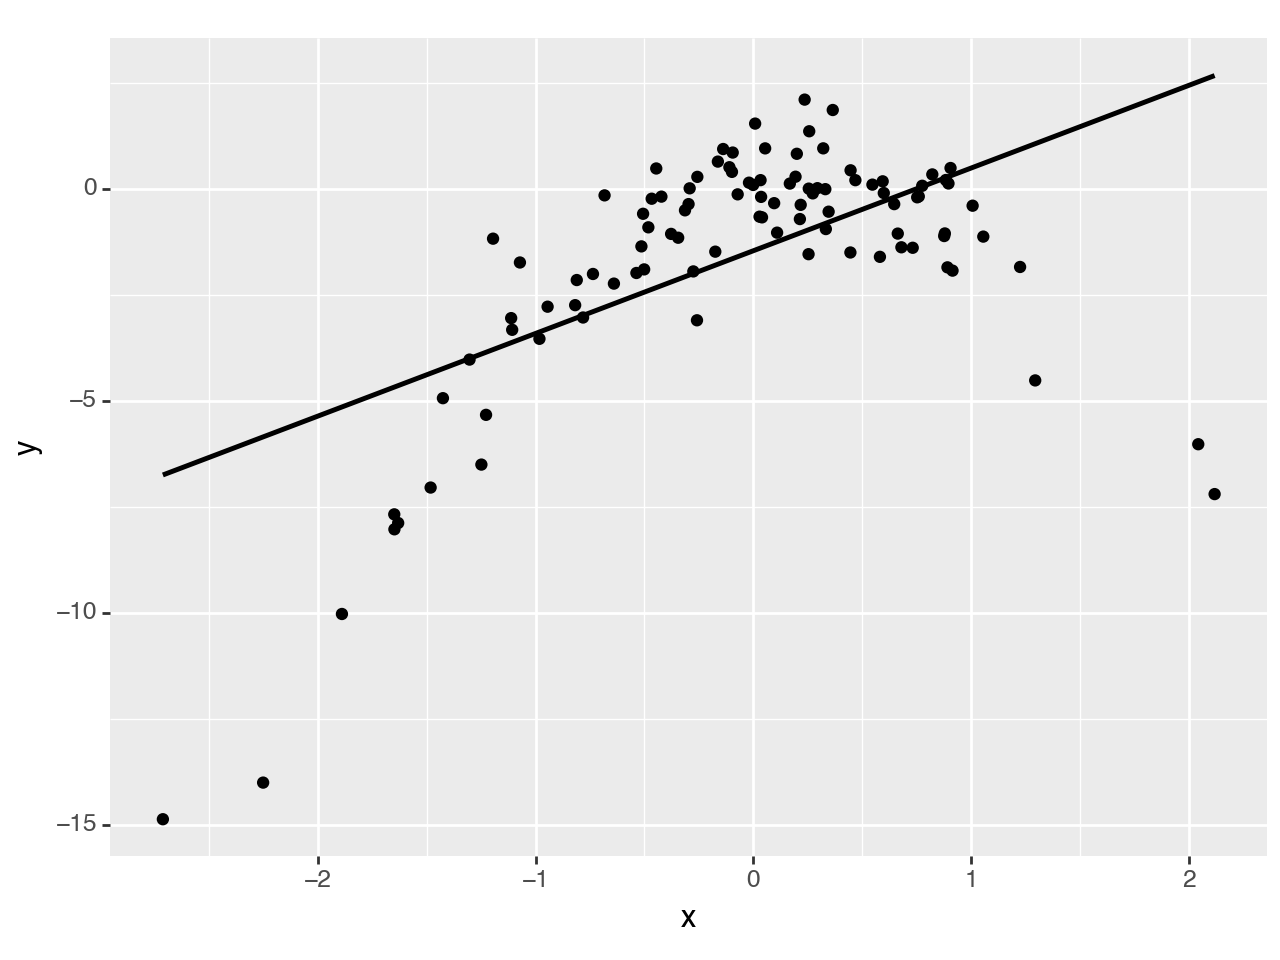

<Figure Size: (640 x 480)>

In [14]:
# 
# Create a scatterplot of X against Y 
(ggplot(pd.DataFrame({'x':x, 'y':y}), aes(x='x', y='y')) +
    geom_point() +
    geom_smooth(method='lm', se=False)
)

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Set a random seed, and then compute the LOOCV errors that result from fitting the following four models using least squares:

i.   $Y = \beta_0 + \beta_1X + \epsilon$
ii.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \epsilon$
iii. $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \epsilon$
iv.  $Y = \beta_0 + \beta_1X + \beta_2X^2 + \beta_3X^3 + \beta_4X^4 + \epsilon$.

Note you may find it helpful to use the `data.frame()` function
to create a single data set containing both $X$ and $Y$ .


Your code:

In [19]:
#
import statsmodels.api as sm
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression


# Set random seed
np.random.seed(100)
# generate random data
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)
# Create a DataFrame to store X and Y
data = pd.DataFrame({'X': x, 'Y': y})

# Add higher powers of X for polynomial regression
data['X2'] = data['X']**2
data['X3'] = data['X']**3
data['X4'] = data['X']**4

# Initialize Leave-One-Out Cross-Validation
loo = LeaveOneOut()

# Function to compute the LOOCV error for a given model
def loocv_error(data, features):
    mse_values = []
    for train_index, test_index in loo.split(data):
        train_data = data.iloc[train_index]
        test_data = data.iloc[test_index]
        model = LinearRegression().fit(train_data[features], train_data['Y'])
        y_pred = model.predict(test_data[features])
        mse_values.append(mean_squared_error(test_data['Y'], y_pred))
    return np.mean(mse_values)

# Compute LOOCV errors for the four models
models = {
    'Model 1': ['X'],
    'Model 2': ['X', 'X2'],
    'Model 3': ['X', 'X2', 'X3'],
    'Model 4': ['X', 'X2', 'X3', 'X4']
}

loocv_errors = {model: loocv_error(data, features) for model, features in models.items()}
loocv_errors

 


 

{'Model 1': 5.772817045970772,
 'Model 2': 1.1563879346405441,
 'Model 3': 1.190355470208168,
 'Model 4': 1.1865709751492122}

Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Repeat (c) using another random seed, and report your results.
Are your results the same as what you got in (c)? Why?

Your code:


In [21]:
#
#

rng = np.random.default_rng(42)
x_new = rng.normal(size=100)
y_new = x_new - 2 * x_new**2 + rng.normal(size=100)

# Create a new DataFrame with the newly generated data
data_new = pd.DataFrame({'X': x_new, 'Y': y_new})
data_new['X2'] = data_new['X']**2
data_new['X3'] = data_new['X']**3
data_new['X4'] = data_new['X']**4

# Compute LOOCV errors for the four models with the new data
loocv_errors_new = {model: loocv_error(data_new, features) for model, features in models.items()}
loocv_errors_new

{'Model 1': 4.2518828656027745,
 'Model 2': 0.9639984632709349,
 'Model 3': 0.9912711879229296,
 'Model 4': 1.0181801043809162}

Your answer:

~~~
The random seed affects the random numbers generated for the dataset, resulting in a different set of values for X and Y


~~~

(e) Which of the models in (c) had the smallest LOOCV error? Is this what you expected? Explain your answer.

Your code:

In [15]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(f) Comment on the statistical significance of the coefficient estimates that results from fitting each of the models in (c) using least squares. Do these results agree with the conclusions drawn based on the cross-validation results?


Your code:

In [16]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Default 1

In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the `Default` data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

(a) Fit a logistic regression model that uses income and balance to predict default.

Your code:

In [36]:
from ISLP import load_data
default = load_data('Default')
default.head()

default student      balance        income
0      No      No   729.526495  44361.625074
1      No     Yes   817.180407  12106.134700
2      No      No  1073.549164  31767.138947
3      No      No   529.250605  35704.493935
4      No      No   785.655883  38463.495879

In [41]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
default['default'] = label_encoder.fit_transform(default['default'])
# Assuming 'default' is your binary dependent variable and 'income' and 'balance' are independent variables
X = default[['income', 'balance']]
y = default['default']

# Add a constant to the model (if you want an intercept)
X = sm.add_constant(X)

model = sm.Logit(y, X).fit()
model.summary()

 

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Sat, 03 Feb 2024   Pseudo R-squ.:                  0.4594
Time:                        22:20:19   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:

i. Split the sample set into a training set and a validation set.

Your code:

In [42]:
#
#split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
 


Your answer:

~~~
Please write your answer in full sentences.


~~~

ii. Fit a multiple logistic regression model using only the training observations.

Your code:

In [43]:
#
#fit a mutiple logistic regression model using the training data
model = sm.Logit(y_train, X_train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.078256
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                 7000
Model:                          Logit   Df Residuals:                     6997
Method:                           MLE   Df Model:                            2
Date:                Sat, 03 Feb 2024   Pseudo R-squ.:                  0.4743
Time:                        22:22:33   Log-Likelihood:                -547.79
converged:                       True   LL-Null:                       -1042.0
Covariance Type:            nonrobust   LLR p-value:                2.273e-215
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -11.6019      0.522    -22.236      0.000     -12.624     -10.579
income      1.872e-05   5.92e-06      3.163      0.002    7.12e-06    3.03e-05
balance        0.0057      0.000     20.976      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.15 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Your answer:

~~~
Please write your answer in full sentences.


~~~


iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.


Your code:

In [44]:
#
# Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
y_pred
 

6252    0
4684    0
1731    0
4742    0
4521    0
       ..
8014    0
1074    0
3063    0
6487    0
4705    0
Length: 3000, dtype: int64

Your answer:

~~~
Please write your answer in full sentences.


~~~


iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

Your code:

In [45]:
#
#compute the validation set error
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
 

0.9733333333333334

Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.


Your code:

In [22]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.


Your code:

In [23]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Default 2

We continue to consider the use of a logistic regression model to
predict the probability of default using income and balance on the
Default data set. In particular, we will now compute estimates for the
standard errors of the income and balance logistic regression coefficients
in two different ways: (1) using the bootstrap, and (2) using the
standard formula for computing the standard errors in the sm.GLM()
function. Do not forget to set a random seed before beginning your
analysis.

(a) Using the `summarize()` and `sm.GLM()` functions, determine the
estimated standard errors for the coefficients associated with
income and balance in a multiple logistic regression model that
uses both predictors.
Your code:

In [24]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Write a function, `boot_fn()`, that takes as input the Default data
set as well as an index of the observations, and that outputs
the coefficient estimates for income and balance in the multiple
logistic regression model.

Your code:

In [25]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Following the bootstrap example in the lab, use your `boot_fn()`
function to estimate the standard errors of the logistic regression
coefficients for income and balance.


Your code:

In [26]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(d) Comment on the estimated standard errors obtained using the `sm.GLM()` function and using the bootstrap.

Your answer:

~~~
Please write your answer in full sentences.


~~~

### Boston housing data set

We will now consider the Boston housing data set, from the ISLR library.

In [27]:
Boston = load_data("Boston")

(a) Based on this data set, provide an estimate for the population mean of medv. Call this estimate $\hat{\mu}$.

Your code:

In [28]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Provide an estimate of the standard error of $\hat{\mu}$. Interpret this result.
Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.

Your code:

In [29]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Now estimate the standard error of $\hat{\mu}$ using the bootstrap. How does this compare to your answer from (b)?

Your code:

In [30]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) Based on your bootstrap estimate from (c), provide a 95 % confidence
interval for the mean of medv. Compare it to the results
obtained by using `Boston['medv'].std()` and the two standard
error rule (3.9).
Hint: You can approximate a 95% confidence interval using the formula $[\hat{\mu} − 2SE(\hat{\mu}), \hat{\mu} + 2SE(\hat{\mu})]$.

Your code:

In [31]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(e) Based on this data set, provide an estimate, $\hat{\mu}_{med}$, for the median value of medv in the population.

Your code:

In [32]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(f) We now would like to estimate the standard error of $\hat{\mu}_{med}$. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

Your code:

In [33]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~



(g) Based on this data set, provide an estimate for the tenth percentile
of medv in Boston census tracts. Call this quantity $\hat{\mu}_{0.1}$.
(You can use the `np.percentile()` function.)

Your code:

In [34]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(h) Use the bootstrap to estimate the standard error of $\hat{\mu}_{0.1}$. Comment on your findings.

Your code:

In [35]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

## Additional Material

### Cross Validation for Predictive Modeling Platforms in Python

#### scikit-learn

Using platforms like scikit-learn is helpful for things such as cross validation.
There are variants of CV implemented to be used off the shelf
https://scikit-learn.org/stable/modules/cross_validation.html

There are many metrics you can choose from
https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [36]:
ames_raw_comp=ames_raw.loc[:,["SalePrice","Gr Liv Area","Lot Area","Total Bsmt SF"]].dropna()
X=ames_raw_comp.loc[:,["Gr Liv Area","Lot Area","Total Bsmt SF"]]
y=ames_raw_comp.loc[:,"SalePrice"]
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn import svm
from sklearn.linear_model import LinearRegression
clf =  LinearRegression()
## One metric
scores = cross_val_score(clf, X, y, cv=5,scoring="r2")
## Multiple metrics
scoring = ['r2', 'max_error']
scores = cross_validate(clf, X, y, scoring=scoring)

#### PySpark

[Apache Spark](https://spark.apache.org/docs/3.1.3/api/python/index.html) is a popular large data handling platform.  Over the years, they built Machine Learning capabilities in MLlib.

In [37]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
import tempfile

In [38]:
spark = SparkSession.builder.appName("CV_test").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/11 21:04:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [39]:
dataset = spark.createDataFrame(
    [(Vectors.dense([0.0]), 0.0),
     (Vectors.dense([0.4]), 1.0),
     (Vectors.dense([0.5]), 0.0),
     (Vectors.dense([0.6]), 1.0),
     (Vectors.dense([1.0]), 1.0)] * 10,
    ["features", "label"])
lr = LogisticRegression()
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator,
    parallelism=2)
cvModel = cv.fit(dataset)
cvModel.getNumFolds()
cvModel.avgMetrics[0]
evaluator.evaluate(cvModel.transform(dataset))

24/01/11 21:04:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


0.8333333333333333

In [40]:
spark.stop()

#### Resampling  using h2o

On H2O cross validation is embedded in the function calling so you don't need to worry about learning a new wrapper on top of your estimator.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/cross-validation.html

In [41]:
#pip install requests
#pip install tabulate
#pip uninstall h2o
#pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
# load packages and data
import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

##### Starting H2O

To use H2O you need to instantiate it.

In [42]:
# nthreads specifies number of threads. -1 means use all the CPU cores.
# max_mem_size specifies the maximum amount of RAM to use.
localH2O= h2o.init(nthreads = -1, max_mem_size="4g")

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_361"; Java(TM) SE Runtime Environment (build 1.8.0_361-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.361-b09, mixed mode)
  Starting server from /opt/homebrew/lib/python3.11/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb
  JVM stdout: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.out
  JVM stderr: /var/folders/r8/_9frrgnx0rq_kt6_r0yvgwlc0000gn/T/tmpbl2r93zb/h2o_masanaoyajima_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       America/New_York
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    22 days
H2O_cluster_name:           H2O_from_python_masanaoyajima_gs7xs1
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.529 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.11.3 final
--------------------------  ------------------------------------

##### CV with  H2O

In [43]:
# Import the prostate dataset
prostate = h2o.import_file("http://s3.amazonaws.com/h2o-public-test-data/smalldata/prostate/prostate.csv.zip")

# Set the predictor names and the response column name
response = "CAPSULE"
predictors = prostate.names[3:8]

# Convert the response column to a factor
prostate['CAPSULE'] = prostate['CAPSULE'].asfactor()

# Train a GBM model setting nfolds to 5
prostate_gbm = H2OGeneralizedLinearEstimator(nfolds = 5, seed = 1)
prostate_gbm.train(x=predictors, y=response, training_frame=prostate)

# AUC of cross-validated holdout predictions
prostate_gbm.auc(xval=True)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


0.7790697716207187

##### Shut down H2O

In [44]:
h2o.cluster().shutdown(prompt =False)

H2O session _sid_8dc7 closed.
